In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
# Colab: install what we need
!pip install pandas geopandas numpy scikit-learn lightgbm maxentropy rasterio shapely matplotlib seaborn

# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    roc_curve, classification_report
)


  Using cached maxentropy-0.3.0.tar.gz (47 kB)
  Preparing metadata (setup.py) ... done
  Using cached rasterio-1.4.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [16]:
import pandas as pd

# 2.1 Presence & inferred-absence tables
pres_df = pd.read_csv('/content/drive/My Drive/finaldataset/presence_with_env_vars.csv')
abs_df  = pd.read_csv('/content/drive/My Drive/finaldataset/inferred_absences_thinned_with_env_vars_cleaned.csv')

# 2.2 Predictors grid
grid_df = pd.read_csv('/content/drive/My Drive/finaldataset/grid_final_with_env_vars.csv')

# Quick sanity checks
print("Presence rows:", pres_df.shape)
print("Absence rows:",  abs_df.shape)
print("Grid rows:",     grid_df.shape)

print("\n.presence head:")
print(pres_df.head())

print("\n.absence head:")
print(abs_df.head())

print("\n.grid head:")
print(grid_df.head())


Presence rows: (3293, 84)
Absence rows: (7572, 86)
Grid rows: (53873, 83)

.presence head:
                          GLOBAL UNIQUE IDENTIFIER  \
0  URN:CornellLabOfOrnithology:EBIRD:OBS1856077315   
1  URN:CornellLabOfOrnithology:EBIRD:OBS1861382792   
2  URN:CornellLabOfOrnithology:EBIRD:OBS1854824044   
3  URN:CornellLabOfOrnithology:EBIRD:OBS1855436014   
4  URN:CornellLabOfOrnithology:EBIRD:OBS1855437057   

             LAST EDITED DATE  TAXONOMIC ORDER CATEGORY  TAXON CONCEPT ID  \
0  2024-06-13 09:28:40.433245            13250  species  avibase-1F56AB5C   
1  2024-06-13 09:28:40.433245            13250  species  avibase-1F56AB5C   
2  2024-06-13 09:28:40.433245            13250  species  avibase-1F56AB5C   
3  2024-04-24 05:56:46.894793            13250  species  avibase-1F56AB5C   
4  2024-04-24 05:57:54.511657            13250  species  avibase-1F56AB5C   

         COMMON NAME     SCIENTIFIC NAME  SUBSPECIES COMMON NAME  \
0  Bar-bellied Pitta  Hydrornis elliotii             

<ipython-input-20-1b462b130b43>:28: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  gdf = gpd.sjoin(gdf, grid[['gid','geometry']], how='left', predicate='within')


Blocks: pres total 46 → pres in test 9
        abs total 440 → abs in test 88
Train shape: (7565, 90) | Test shape: (3300, 90)
Train pres/abs: {0: 5836, 1: 1729}
Test  pres/abs: {0: 1736, 1: 1564}


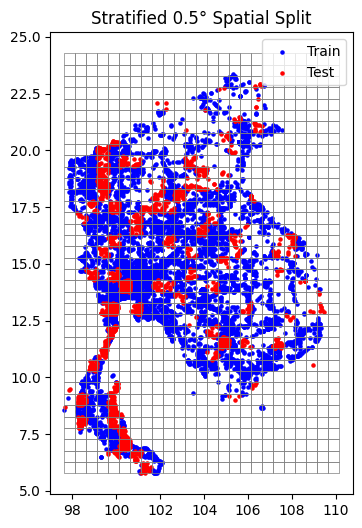

Total features: 33
Missing: []
Balanced train pres/abs: {1: 1729, 0: 1729}
X_train: (3458, 33) | X_test: (3300, 33)


In [20]:
# ─── 0. Prepare GeoDataFrame & grid (reuse pres_df, abs_df) ────────────────
import pandas as pd, numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

# merge
pres_df['presence'] = 1
abs_df ['presence'] = 0
df = pd.concat([pres_df, abs_df], ignore_index=True)

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']),
    crs='EPSG:4326'
)

# build 0.5° grid
minx, miny, maxx, maxy = gdf.total_bounds
cell = 0.5
polys = [box(x, y, x+cell, y+cell)
         for x in np.arange(minx, maxx+cell, cell)
         for y in np.arange(miny, maxy+cell, cell)]
grid = gpd.GeoDataFrame({'geometry':polys})
grid['gid'] = grid.index

# spatial join → assign gid to each point
gdf = gpd.sjoin(gdf, grid[['gid','geometry']], how='left', predicate='within')

# ─── 1. Stratified block sampling ───────────────────────────────────────────
# count presences per block
block_stats = gdf.groupby('gid')['presence'].sum().reset_index(name='pres_count')
block_stats['has_pres'] = block_stats['pres_count'] > 0

pres_blocks = block_stats[block_stats['has_pres']]['gid']
abs_blocks = block_stats[~block_stats['has_pres']]['gid']

np.random.seed(42)
n_pres_test = int(0.2 * len(pres_blocks))
n_abs_test  = int(0.2 * len(abs_blocks))

test_pres = np.random.choice(pres_blocks, size=n_pres_test, replace=False)
test_abs  = np.random.choice(abs_blocks, size=n_abs_test,  replace=False)
test_gids = np.concatenate([test_pres, test_abs])

train = gdf[~gdf['gid'].isin(test_gids)].copy()
test  = gdf[ gdf['gid'].isin(test_gids)].copy()

print("Blocks: pres total", len(pres_blocks), "→ pres in test", n_pres_test)
print("        abs total",  len(abs_blocks), "→ abs in test",  n_abs_test)
print("Train shape:", train.shape, "| Test shape:", test.shape)
print("Train pres/abs:", train['presence'].value_counts().to_dict())
print("Test  pres/abs:", test ['presence'].value_counts().to_dict())

# ─── 2. Plot train/test on map ───────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8,6))
grid.boundary.plot(ax=ax, color='gray', linewidth=0.5)
train.plot(ax=ax, color='blue',  markersize=5, label='Train')
test .plot(ax=ax, color='red',   markersize=5, label='Test')
ax.set_title("Stratified 0.5° Spatial Split")
ax.legend(); plt.show()

# ─── 3. Define features (bioclim, static, effort) ──────────────────────────
# auto-detect BIOCLIM and elevation
bioclim = [c for c in train.columns if c.upper().startswith('BIO')]
static_env = [
    'ELEVATION','SLOPE','ASPECT','RUGGEDNESS','LAND_COVER_CODE',
    'distance_to_road_meters','distance_to_railroad_meters',
    'distance_to_urban_area_meters','distance_to_river_meters',
    'distance_to_lake_meters'
]
effort = ['DURATION MINUTES','EFFORT DISTANCE KM','EFFORT AREA HA','NUMBER OBSERVERS']

feature_cols = bioclim + static_env + effort
print("Total features:", len(feature_cols))
print("Missing:", [c for c in feature_cols if c not in train.columns])

# ─── 4. Handle class imbalance in training ───────────────────────────────────
from sklearn.utils import resample

train_pres = train[train['presence']==1]
train_abs  = train[train['presence']==0]

train_abs_down = resample(
    train_abs,
    replace=False,
    n_samples=len(train_pres),
    random_state=42
)

train_bal = pd.concat([train_pres, train_abs_down], ignore_index=True)
print("Balanced train pres/abs:", train_bal['presence'].value_counts().to_dict())

# ─── 5. Build final X/y ────────────────────────────────────────────────────
X_train = train_bal[feature_cols]
y_train = train_bal['presence']
X_test  = test [feature_cols]
y_test  = test ['presence']

print("X_train:", X_train.shape, "| X_test:", X_test.shape)


Before imputation, missing in X_train:
 SLOPE                  146
DURATION MINUTES       198
EFFORT DISTANCE KM     545
EFFORT AREA HA        3452
NUMBER OBSERVERS        98
dtype: int64
Before imputation, missing in X_test:
 SLOPE                  126
DURATION MINUTES       256
EFFORT DISTANCE KM     435
EFFORT AREA HA        3297
NUMBER OBSERVERS       130
dtype: int64
After imputation, any missing in X_train_imp? False
After imputation, any missing in X_test_imp?  False


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1729, number of negative: 1729
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7346
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== LogReg_bal ===
Accuracy : 0.9178787878787878
ROC AUC  : 0.9695937982486122
Confusion Matrix:
 [[1591  145]
 [ 126 1438]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1736
           1       0.91      0.92      0.91      1564

    accuracy                           0.92      3300
   macro avg       0.92      0.92      0.92      3300
weighted avg       0.92      0.92      0.92      3300


=== RandomForest ===
Accuracy : 0.9878787878787879
ROC AUC  : 0.9964859541291973
Confusion Matrix:
 [[1720   16]
 [  24 1540]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1736
           1       0.99      0.98      0.99      1564

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300


=== LightGBM ===
Accuracy : 0.9860606060606061
ROC AUC  : 0.9990195587351349
Confusion Matr

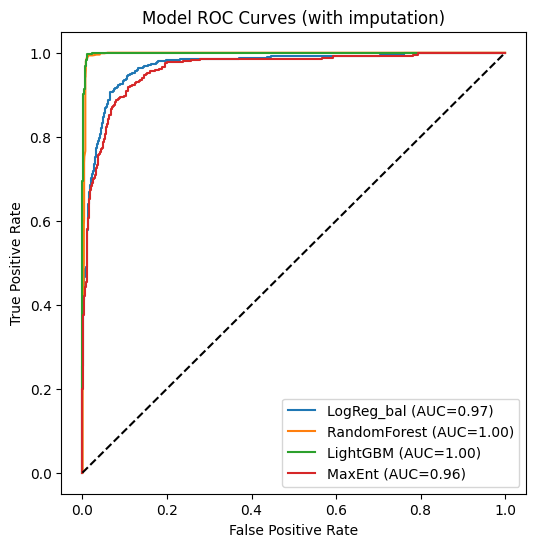

In [23]:
# ─── A. Imputation (as before) ─────────────────────────────────────────────
from sklearn.impute import SimpleImputer

print("Before imputation, missing in X_train:\n", X_train.isnull().sum()[X_train.isnull().sum()>0])
print("Before imputation, missing in X_test:\n",  X_test .isnull().sum()[X_test .isnull().sum()>0])

imputer = SimpleImputer(strategy='median')
X_train_imp   = pd.DataFrame(imputer.fit_transform(X_train),   columns=feature_cols)
X_test_imp    = pd.DataFrame(imputer.transform(X_test),        columns=feature_cols)
X_train_raw   = train[feature_cols]
X_train_raw_imp = pd.DataFrame(imputer.transform(X_train_raw), columns=feature_cols)

print("After imputation, any missing in X_train_imp?", X_train_imp.isnull().any().any())
print("After imputation, any missing in X_test_imp? ", X_test_imp.isnull().any().any())

# Redefine y_train_raw for pseudo‐MaxEnt
y_train_raw = train['presence']

# ─── B. Retrain & evaluate ─────────────────────────────────────────────────
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble      import RandomForestClassifier
from lightgbm              import LGBMClassifier
from sklearn.metrics       import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import matplotlib.pyplot    as plt

# 1. Logistic Regression on BALANCED (imputed)
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_imp, y_train)
prob_lr = lr.predict_proba(X_test_imp)[:,1]
pred_lr = lr.predict(X_test_imp)

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_imp, y_train)
prob_rf = rf.predict_proba(X_test_imp)[:,1]
pred_rf = rf.predict(X_test_imp)

# 3. LightGBM
lgb = LGBMClassifier(n_estimators=200, random_state=42)
lgb.fit(X_train_imp, y_train)
prob_lgb = lgb.predict_proba(X_test_imp)[:,1]
pred_lgb = lgb.predict(X_test_imp)

# 4. Pseudo-MaxEnt on RAW (imputed)
maxent_lr = LogisticRegression(max_iter=2000)
maxent_lr.fit(X_train_raw_imp, y_train_raw)
prob_maxent = maxent_lr.predict_proba(X_test_imp)[:,1]
pred_maxent = maxent_lr.predict(X_test_imp)

# Collect for evaluation
models = {
    'LogReg_bal':    (pred_lr,    prob_lr),
    'RandomForest':  (pred_rf,    prob_rf),
    'LightGBM':      (pred_lgb,   prob_lgb),
    'MaxEnt':        (pred_maxent,prob_maxent)
}

# Print metrics
for name, (pred, prob) in models.items():
    print(f"\n=== {name} ===")
    print("Accuracy :", accuracy_score(y_test, pred))
    print("ROC AUC  :", roc_auc_score(y_test, prob))
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))

# Plot ROC curves
plt.figure(figsize=(6,6))
for name, (_, prob) in models.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, prob):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Model ROC Curves (with imputation)")
plt.legend()
plt.show()


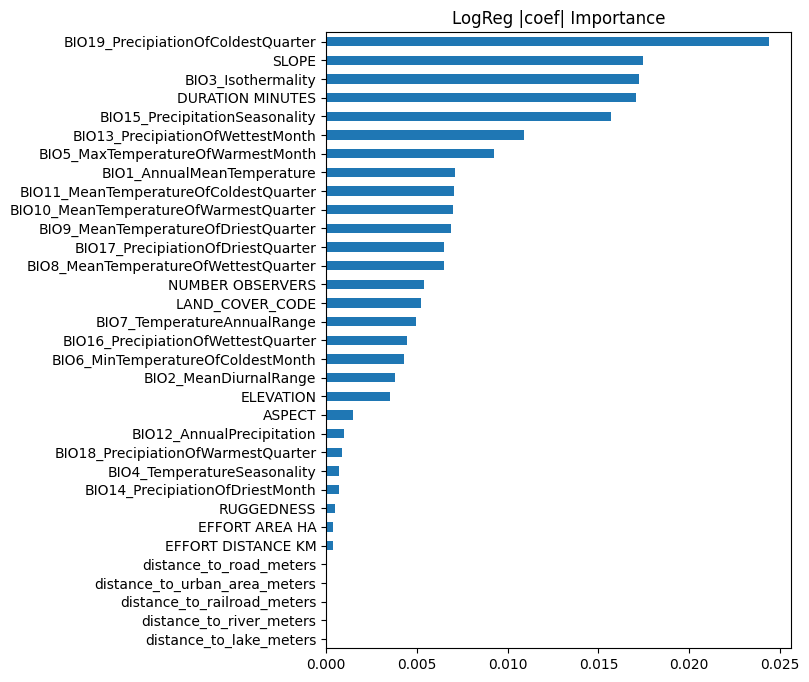

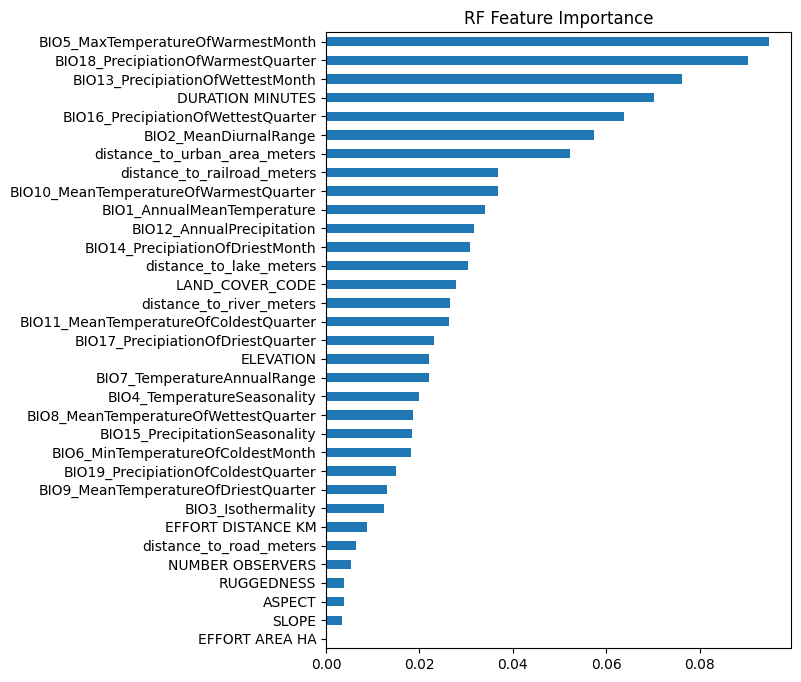

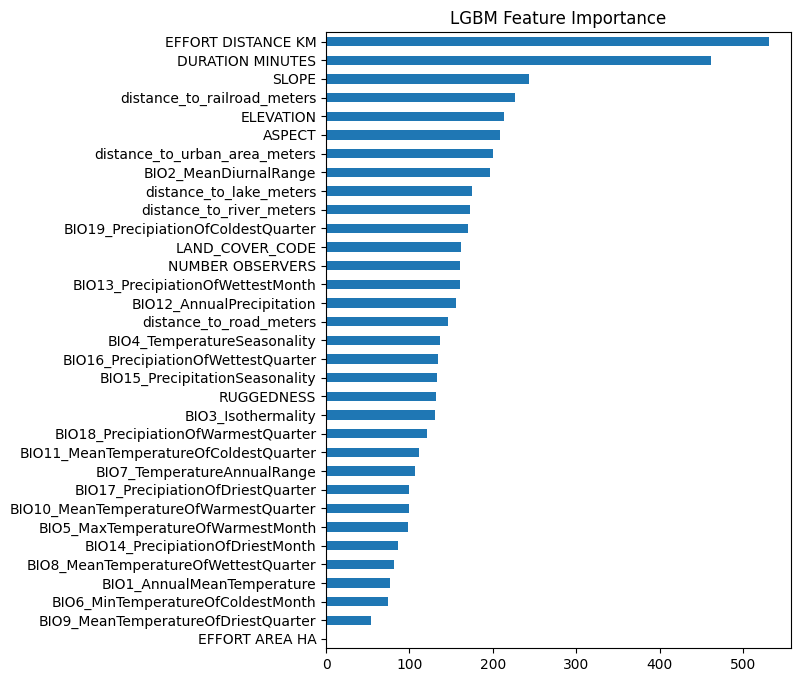

LogReg_bal — Train AUC: 0.954, Test AUC: 0.970
RF — Train AUC: 1.000, Test AUC: 0.996
LGB — Train AUC: 1.000, Test AUC: 0.999
MaxEnt — Train AUC: 0.949, Test AUC: 0.962


ValueError: too many values to unpack (expected 2)

In [24]:
# 8. Feature importance, overfit diagnostics, threshold selection & PDPs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay

# 8.1 Logistic Regression coefficients
coef = pd.Series(lr.coef_[0], index=feature_cols).abs().sort_values()
plt.figure(figsize=(6,8))
coef.plot.barh()
plt.title("LogReg |coef| Importance")
plt.show()

# 8.2 Random Forest importances
imp_rf = pd.Series(rf.feature_importances_, index=feature_cols).sort_values()
plt.figure(figsize=(6,8))
imp_rf.plot.barh()
plt.title("RF Feature Importance")
plt.show()

# 8.3 LightGBM importances
imp_lgb = pd.Series(lgb.feature_importances_, index=feature_cols).sort_values()
plt.figure(figsize=(6,8))
imp_lgb.plot.barh()
plt.title("LGBM Feature Importance")
plt.show()

# 8.4 Overfitting check: Train vs Test AUC
for name, model in [
    ("LogReg_bal", lr),
    ("RF", rf),
    ("LGB", lgb),
    ("MaxEnt", maxent_lr)
]:
    # pick correct train set for MaxEnt vs others
    if name=="MaxEnt":
        Xtr, ytr = X_train_raw_imp, y_train_raw
    else:
        Xtr, ytr = X_train_imp, y_train
    auc_tr = roc_auc_score(ytr, model.predict_proba(Xtr)[:,1])
    auc_te = roc_auc_score(y_test, model.predict_proba(X_test_imp)[:,1])
    print(f"{name} — Train AUC: {auc_tr:.3f}, Test AUC: {auc_te:.3f}")

# 8.5 Optimal threshold & confusion matrices
opt_thresh = {}
for name, (_, prob) in {
    "LogReg_bal": prob_lr,
    "RF":          prob_rf,
    "LGB":        prob_lgb,
    "MaxEnt":    prob_maxent
}.items():
    fpr, tpr, thr = roc_curve(y_test, prob)
    j      = tpr - fpr
    best_i = np.argmax(j)
    best_t = thr[best_i]
    opt_thresh[name] = best_t
    y_opt = (prob >= best_t).astype(int)
    print(f"\n{name} optimal thresh = {best_t:.3f}")
    print("Confusion matrix:\n", confusion_matrix(y_test, y_opt))

print("\nAll optimal thresholds:", opt_thresh)

# 8.6 PDPs for top 2 RF features
top2 = imp_rf.sort_values(ascending=False).index[:2].tolist()
print("Top 2 RF features:", top2)
for feat in top2:
    disp = PartialDependenceDisplay.from_estimator(
        rf, X_train_imp, [feat], kind='average', grid_resolution=50
    )
    plt.title(f"PDP for {feat}")
    plt.show()


In [25]:
# Top 10 for each
def top_feats(scores, names, n=10):
    return pd.Series(scores, index=names).abs().sort_values(ascending=False).head(n)

print("LogReg top 10 coefficients:")
print(top_feats(lr.coef_[0], feature_cols))

print("\nRandomForest top 10 importances:")
print(top_feats(rf.feature_importances_, feature_cols))

print("\nLightGBM top 10 importances:")
print(top_feats(lgb.feature_importances_, feature_cols))

print("\nMaxEnt (pseudo-LR) top 10 coefficients:")
print(top_feats(maxent_lr.coef_[0], feature_cols))


LogReg top 10 coefficients:
BIO19_PrecipiationOfColdestQuarter       0.024396
SLOPE                                    0.017432
BIO3_Isothermality                       0.017247
DURATION MINUTES                         0.017064
BIO15_PrecipitationSeasonality           0.015698
BIO13_PrecipiationOfWettestMonth         0.010901
BIO5_MaxTemperatureOfWarmestMonth        0.009226
BIO1_AnnualMeanTemperature               0.007082
BIO11_MeanTemperatureOfColdestQuarter    0.007026
BIO10_MeanTemperatureOfWarmestQuarter    0.006975
dtype: float64

RandomForest top 10 importances:
BIO5_MaxTemperatureOfWarmestMonth        0.094844
BIO18_PrecipiationOfWarmestQuarter       0.090402
BIO13_PrecipiationOfWettestMonth         0.076314
DURATION MINUTES                         0.070257
BIO16_PrecipiationOfWettestQuarter       0.063755
BIO2_MeanDiurnalRange                    0.057469
distance_to_urban_area_meters            0.052134
distance_to_railroad_meters              0.036769
BIO10_MeanTemperatureOf

In [26]:
# Define only environmental features (remove effort variables)
habitat_feats = [f for f in feature_cols if f not in effort]


In [27]:
# Habitat-only models
X_train_hab = X_train_imp[habitat_feats]
X_test_hab = X_test_imp[habitat_feats]

# Train Random Forest and LightGBM on habitat-only data
rf_hab = RandomForestClassifier(n_estimators=200, random_state=42)
rf_hab.fit(X_train_hab, y_train)
print("RF (habitat-only) AUC:", roc_auc_score(y_test, rf_hab.predict_proba(X_test_hab)[:,1]))

lgb_hab = LGBMClassifier(n_estimators=200, random_state=42)
lgb_hab.fit(X_train_hab, y_train)
print("LGB (habitat-only) AUC:", roc_auc_score(y_test, lgb_hab.predict_proba(X_test_hab)[:,1]))


RF (habitat-only) AUC: 0.9959758447558547
[LightGBM] [Info] Number of positive: 1729, number of negative: 1729
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6832
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [28]:
# Compare AUC on Train vs Test
for name, model in [
    ("RF (habitat-only)", rf_hab),
    ("LGB (habitat-only)", lgb_hab)
]:
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train_hab)[:,1])
    auc_test  = roc_auc_score(y_test, model.predict_proba(X_test_hab)[:,1])
    print(f"{name} — Train AUC: {auc_train:.3f}, Test AUC: {auc_test:.3f}")


RF (habitat-only) — Train AUC: 1.000, Test AUC: 0.996
LGB (habitat-only) — Train AUC: 1.000, Test AUC: 0.994


In [29]:
# Habitat-only model (exclude effort features)
habitat_feats = [f for f in feature_cols if f not in effort]
print("Habitat-only features:", habitat_feats)

# Train RF on habitat-only features
rf_hab = RandomForestClassifier(n_estimators=200, random_state=42)
rf_hab.fit(X_train_imp[habitat_feats], y_train)
print("RF (habitat-only) AUC:", roc_auc_score(y_test, rf_hab.predict_proba(X_test_imp[habitat_feats])[:,1]))

# Encounter-rate model (only effort features)
enc_feats = effort
print("Encounter-rate features:", enc_feats)

# Train Logistic Regression on effort features
lr_enc = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_enc.fit(X_train_imp[enc_feats], y_train)
print("LR (encounter-rate) AUC:", roc_auc_score(y_test, lr_enc.predict_proba(X_test_imp[enc_feats])[:,1]))


Habitat-only features: ['BIO1_AnnualMeanTemperature', 'BIO2_MeanDiurnalRange', 'BIO3_Isothermality', 'BIO4_TemperatureSeasonality', 'BIO5_MaxTemperatureOfWarmestMonth', 'BIO6_MinTemperatureOfColdestMonth', 'BIO7_TemperatureAnnualRange', 'BIO8_MeanTemperatureOfWettestQuarter', 'BIO9_MeanTemperatureOfDriestQuarter', 'BIO10_MeanTemperatureOfWarmestQuarter', 'BIO11_MeanTemperatureOfColdestQuarter', 'BIO12_AnnualPrecipitation', 'BIO13_PrecipiationOfWettestMonth', 'BIO14_PrecipiationOfDriestMonth', 'BIO15_PrecipitationSeasonality', 'BIO16_PrecipiationOfWettestQuarter', 'BIO17_PrecipiationOfDriestQuarter', 'BIO18_PrecipiationOfWarmestQuarter', 'BIO19_PrecipiationOfColdestQuarter', 'ELEVATION', 'SLOPE', 'ASPECT', 'RUGGEDNESS', 'LAND_COVER_CODE', 'distance_to_road_meters', 'distance_to_railroad_meters', 'distance_to_urban_area_meters', 'distance_to_river_meters', 'distance_to_lake_meters']
RF (habitat-only) AUC: 0.9959758447558547
Encounter-rate features: ['DURATION MINUTES', 'EFFORT DISTANCE K

In [32]:
# 1. Refit the imputer on the habitat features (environmental variables) only
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train_imp[habitat_feats])  # Fit only on habitat features

# 2. Impute missing values in the buffered training set (only habitat features)
X_train_buf = pd.DataFrame(imputer.transform(train_buf_hab), columns=habitat_feats)

# 3. Extract the target variable (presence) from the buffered train set
y_train_buf = train_buf['presence']

# 4. Retrain RF (habitat-only) on the buffered train set
rf_buf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_buf.fit(X_train_buf, y_train_buf)

# 5. Evaluate on the test set using the habitat features (same habitat features as used in training)
print("RF (buffered) AUC:", roc_auc_score(y_test, rf_buf.predict_proba(X_test_imp[habitat_feats])[:,1]))


IndexError: index 1 is out of bounds for axis 1 with size 1